### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /shared/home/model/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Preparation

- Loads and preprocesses SMS data.  
- Converts labels to binary (spam = 1, ham = 0).  
- Cleans text by removing special characters, stopwords, and extra spaces.  
- Removes duplicate messages.  
- Handles outliers based on message length.  
- Performs exploratory data analysis (EDA) with visualizations.  
- Prepares features like text length and word count.  
- Splits data into train, validation, and test sets.  
- Analyzes correlations between features and labels.  
- Saves processed data for further use.

In [2]:
class DataPreparation:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def load_data(self, filepath):
        """Load SMS data from given filepath"""
        try:
            # Read data with tab separator
            df = pd.read_csv(filepath, sep='\t', names=['label', 'message'])

            # Verify data format
            print("\nInitial data shape:", df.shape)
            print("\nSample of loaded data:")
            print(df.head())

            # Convert labels to standard format
            df['label'] = df['label'].str.lower()  # Convert to lowercase
            if not all(df['label'].isin(['ham', 'spam'])):
                raise ValueError("Labels must be either 'ham' or 'spam'")

            # Convert labels to numeric (0 for ham, 1 for spam)
            df['label'] = (df['label'] == 'spam').astype(int)

            # Check for missing values
            missing = df.isnull().sum()
            if missing.any():
                print("\nWarning: Found missing values:")
                print(missing[missing > 0])

                # Fill missing messages with empty string
                df['message'] = df['message'].fillna('')

            print(f"\nLoaded {len(df)} messages")
            print("\nLabel distribution:")
            print(df['label'].value_counts(normalize=True))
            print("\nLabel mapping: 0=ham, 1=spam")

            return df
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def clean_text(self, text):
        """Clean text data"""
        try:
            # Handle empty or NaN values
            if pd.isna(text) or str(text).strip() == '':
                print(f"Warning: Empty text found")
                return ''

            # Convert to string and lowercase
            text = str(text).lower()

            # Remove special characters and digits
            text = re.sub(r'[^a-zA-Z\s]', ' ', text)

            # Remove extra whitespace
            text = ' '.join(text.split())

            # Remove stopwords
            if text:  # Only if text is not empty
                words = text.split()
                words = [w for w in words if w not in self.stop_words]
                text = ' '.join(words)

            # If after cleaning text is empty, return placeholder
            if not text.strip():
                return 'empty_message'

            return text
        except Exception as e:
            print(f"Error cleaning text: {str(e)}")
            return 'error_in_cleaning'

    def remove_duplicates(self, df):
        """Remove duplicate messages"""
        initial_size = len(df)
        df = df.drop_duplicates(subset=['message'])
        final_size = len(df)
        print(f"Removed {initial_size - final_size} duplicate messages")
        return df

    def handle_outliers(self, df):
        """Handle outlier messages based on length"""
        df['message_length'] = df['message'].str.len()
        Q1 = df['message_length'].quantile(0.25)
        Q3 = df['message_length'].quantile(0.75)
        IQR = Q3 - Q1
        df = df[
            (df['message_length'] >= Q1 - 1.5 * IQR) &
            (df['message_length'] <= Q3 + 1.5 * IQR)
        ]
        df = df.drop('message_length', axis=1)
        return df

    def analyze_data(self, df):
        """Perform exploratory data analysis"""
        print("\nPerforming EDA...")

        # Message length distribution
        df['message_length'] = df['message'].str.len()

        # Plot distributions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Label distribution
        sns.countplot(x='label', data=df, ax=ax1)
        ax1.set_title('Distribution of Labels')

        # Message length by label
        sns.boxplot(x='label', y='message_length', data=df, ax=ax2)
        ax2.set_title('Message Length by Label')

        plt.tight_layout()
        plt.savefig('eda_plots.png')
        plt.close()

        # Print statistics
        print("\nLabel Distribution:")
        print(df['label'].value_counts(normalize=True))

        print("\nMessage Length Statistics:")
        print(df.groupby('label')['message_length'].describe())

        df = df.drop('message_length', axis=1)
        return df

    def prepare_features(self, df):
        """Prepare features"""
        print("\nPreparing features...")

        # Ensure message column is string type
        df['message'] = df['message'].fillna('').astype(str)

        # Clean messages
        print("Cleaning text data...")
        df['processed_text'] = df['message'].apply(self.clean_text)

        # Check for empty processed texts
        empty_texts = df['processed_text'].str.strip() == ''
        if empty_texts.any():
            print(f"Warning: Found {empty_texts.sum()} empty texts after processing")
            # Replace empty texts with placeholder
            df.loc[empty_texts, 'processed_text'] = 'empty_message'

        # Verify processed data
        print("\nSample of processed texts:")
        print(df[['message', 'processed_text']].head())

        # Count unique processed texts
        n_unique = df['processed_text'].nunique()
        print(f"\nNumber of unique processed texts: {n_unique}")

        return df

    def split_data(self, df, train_size=0.7, val_size=0.15):
        """Split data into train/validation/test sets"""
        print("\nSplitting data...")

        # Verify data before splitting
        if df['processed_text'].isna().any():
            raise ValueError("Found NaN values in processed_text")

        if df['label'].isna().any():
            raise ValueError("Found NaN values in labels")

        # Verify label distribution
        label_dist = df['label'].value_counts()
        print("\nLabel distribution before splitting:")
        print(label_dist)

        if len(label_dist) != 2:
            raise ValueError(f"Expected 2 classes, found {len(label_dist)}")

        # Perform stratified split
        train_df, temp_df = train_test_split(
            df,
            train_size=train_size,
            stratify=df['label'],
            random_state=42
        )

        # Split temp into validation and test
        val_size_adjusted = val_size / (1 - train_size)
        val_df, test_df = train_test_split(
            temp_df,
            train_size=val_size_adjusted,
            stratify=temp_df['label'],
            random_state=42
        )

        # Verify splits
        print(f"\nTrain set: {len(train_df)} samples")
        print(f"Validation set: {len(val_df)} samples")
        print(f"Test set: {len(test_df)} samples")

        # Verify label distribution in splits
        print("\nLabel distribution in splits:")
        print("Train:", train_df['label'].value_counts(normalize=True))
        print("Validation:", val_df['label'].value_counts(normalize=True))
        print("Test:", test_df['label'].value_counts(normalize=True))

        return train_df, val_df, test_df

    def save_splits(self, train_df, val_df, test_df):
        """Save the data splits"""
        # Final verification
        for name, df in [('train', train_df), ('validation', val_df), ('test', test_df)]:
            # Check for required columns
            if not {'label', 'processed_text'}.issubset(df.columns):
                raise ValueError(f"Missing required columns in {name} set")

            # Check for empty texts
            empty = df['processed_text'].str.strip() == ''
            if empty.any():
                print(f"Warning: Found {empty.sum()} empty texts in {name} set")

            # Check label distribution
            print(f"\n{name.capitalize()} set label distribution:")
            print(df['label'].value_counts(normalize=True))

        # Save to CSV
        train_df.to_csv('train.csv', index=False)
        val_df.to_csv('validation.csv', index=False)
        test_df.to_csv('test.csv', index=False)

        print("\nData splits saved successfully")

    def analyze_correlations(self, df):
        """Analyze feature correlations and interactions"""
        print("\nAnalyzing feature correlations...")

        # Create basic text features
        df['text_length'] = df['processed_text'].str.len()
        df['word_count'] = df['processed_text'].str.split().str.len()
        df['avg_word_length'] = df['text_length'] / df['word_count']

        # Analyze correlations with target
        numeric_features = ['text_length', 'word_count', 'avg_word_length']
        correlations = df[numeric_features + ['label']].corr()['label'].sort_values()

        plt.figure(figsize=(10, 6))
        correlations.plot(kind='bar')
        plt.title('Feature Correlations with Target')
        plt.tight_layout()
        plt.show()

        return df

    def run_preparation(self, filepath):
        """Run the full data preparation pipeline"""
        print("Starting data preparation...")

        # Load data
        df = self.load_data(filepath)

        # Remove duplicates
        df = self.remove_duplicates(df)

        # Handle outliers
        df = self.handle_outliers(df)

        # Analyze data
        df = self.analyze_data(df)

        # Prepare features
        df = self.prepare_features(df)

        # Add correlation analysis
        df = self.analyze_correlations(df)

        # Split data
        train_df, val_df, test_df = self.split_data(df)

        # Save splits
        self.save_splits(train_df, val_df, test_df)

        return train_df, val_df, test_df

Starting data preparation...

Initial data shape: (5572, 2)

Sample of loaded data:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Loaded 5572 messages

Label distribution:
label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

Label mapping: 0=ham, 1=spam
Removed 403 duplicate messages

Performing EDA...



Label Distribution:
label
0    0.872086
1    0.127914
Name: proportion, dtype: float64

Message Length Statistics:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
0      4452.0   66.897350  43.656041   2.0   33.0   52.0   88.0  243.0
1       653.0  137.704441  29.821348  13.0  132.0  148.0  157.0  223.0

Preparing features...
Cleaning text data...

Sample of processed texts:
                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                      processed_text  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp w

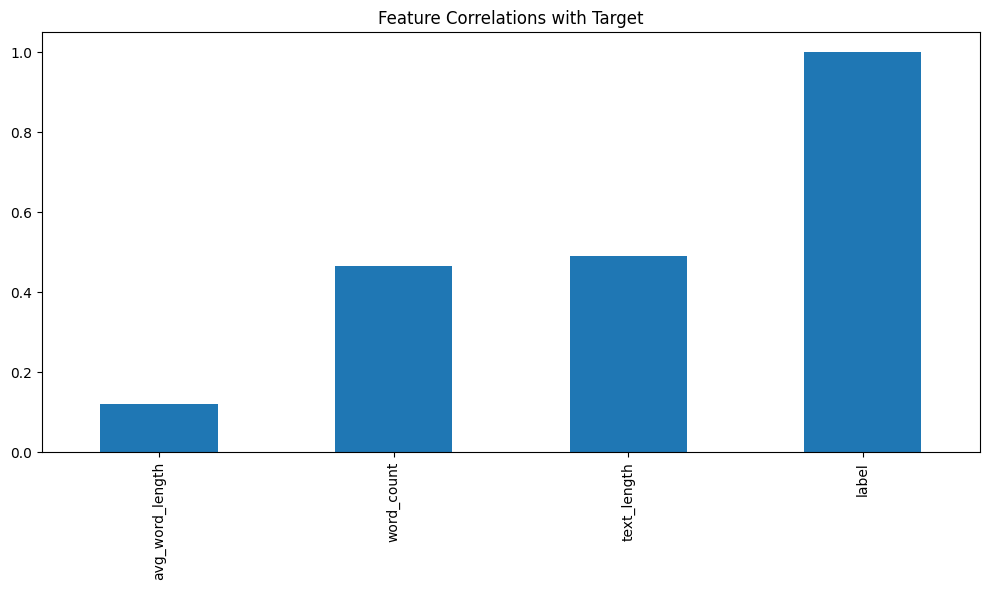


Splitting data...

Label distribution before splitting:
label
0    4452
1     653
Name: count, dtype: int64

Train set: 3573 samples
Validation set: 765 samples
Test set: 767 samples

Label distribution in splits:
Train: label
0    0.872096
1    0.127904
Name: proportion, dtype: float64
Validation: label
0    0.871895
1    0.128105
Name: proportion, dtype: float64
Test: label
0    0.872229
1    0.127771
Name: proportion, dtype: float64

Train set label distribution:
label
0    0.872096
1    0.127904
Name: proportion, dtype: float64

Validation set label distribution:
label
0    0.871895
1    0.128105
Name: proportion, dtype: float64

Test set label distribution:
label
0    0.872229
1    0.127771
Name: proportion, dtype: float64

Data splits saved successfully


In [6]:
data_prep = DataPreparation()
train_df, val_df, test_df = data_prep.run_preparation("SMSSpamCollection")